# NATURAL LANGUAGE PROCESSING COURSEWORK - EXPERIMENTS OVERVIEW

**This notebook serves as the main entry point coursework experiments. It will include a series of experiments to evaluate different models and techniques for Named Entity Recognition (NER).**

Each experiment will be conducted in a separate notebook, linked from this main notebook for easy access and organization. 

In this section, an exploratory data analysis will be conducted on the dataset to gain insights into the distribution of tokens, named entities, the frequency of different entity types, and other relevant statistics. This helps us better understand what data we are dealing with before proceeding with model trainings.

## IMPORTS

In [22]:
import nltk
import torch
import wandb
import string
import torchtext
import random
import warnings
import multiprocessing
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.layers import Flatten
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from gensim.models.keyedvectors import KeyedVectors
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from wordcloud import WordCloud
from tensorflow.keras.layers import (
    Embedding, 
    Conv1D, 
    GlobalMaxPooling1D, 
    Dense, 
    TimeDistributed,
    LSTM,
    Bidirectional
)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import (
    AdamW,
    AutoTokenizer,
    AutoModel,
    AutoModelForTokenClassification,
    BertTokenizerFast,
    BertModel,
    BertForTokenClassification,
    RobertaTokenizer,
    RobertaModel,
    RobertaTokenizerFast,
    EarlyStoppingCallback,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification,
)
from gensim.models import (
    Word2Vec,
    FastText
)
from transformers.trainer_utils import EvalPrediction
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from tqdm.notebook import tqdm
from collections import Counter
from IPython.display import display, HTML
from nltk.corpus import stopwords
from seqeval.metrics import classification_report

# Ignore FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)


## EXPLORATORY DATA ANALYSIS

### DATA LOADING

In [23]:
datasets = load_dataset("surrey-nlp/PLOD-CW")

### DATASET OVERVIEW

In [24]:
datasets 

DatasetDict({
    train: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 1072
    })
    validation: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 126
    })
    test: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 153
    })
})

In [25]:
# Funtion to display random rows 
def display_random_rows(dataset, num_rows=5):
    random_rows = datasets['train'].shuffle(seed=42).select(range(num_rows))
    random_rows_df = pd.DataFrame(random_rows)
    display(HTML(random_rows_df.to_html()))

In [26]:
display_random_rows(datasets['train'])

,tokens,pos_tags,ner_tags
0,"[Mice, that, need, to, be, perfused, with, PBS, and/or, 4, %, paraformaldehyde, (, PFA, ), prior, to, tissue, harvest, were, anesthetized, with, a, combination, of, ketamine, (, 20, mg, /, kg, body, weight, ), and, xylazine, (, 2, mg, /, kg, body, weight, ), .]","[NOUN, PRON, VERB, ADP, AUX, VERB, ADP, PROPN, CCONJ, NUM, NOUN, NOUN, PUNCT, PROPN, PUNCT, ADV, ADP, NOUN, NOUN, AUX, VERB, ADP, DET, NOUN, ADP, NOUN, PUNCT, NUM, NOUN, SYM, NOUN, NOUN, NOUN, PUNCT, CCONJ, NOUN, PUNCT, NUM, NOUN, SYM, NOUN, NOUN, NOUN, PUNCT, PUNCT]","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-AC, B-O, B-O, B-O, B-LF, B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O]"
1,"[This, indicates, that, a, Chromosome, 4, bivalent, experiences, on, average, 1.76, CO, in, male, meiosis, ,, but, only, 1.05, CO, in, female, meiosis, (, M, /, F, ratio, 1.68, ), .]","[PRON, VERB, SCONJ, DET, NOUN, NUM, ADJ, VERB, ADP, ADJ, NUM, PROPN, ADP, ADJ, NOUN, PUNCT, CCONJ, ADV, NUM, PROPN, ADP, ADJ, NOUN, PUNCT, PROPN, SYM, PROPN, NOUN, NUM, PUNCT, PUNCT]","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-AC, B-O, B-LF, B-O, B-O, B-O, B-O, B-O, B-AC, B-O, B-LF, B-O, B-O, B-AC, B-O, B-AC, B-O, B-O, B-O, B-O]"
2,"[Within, the, first, week, after, surgery, ,, 7.7, ±, 0.6, %, of, dendritic, spines, were, eliminated, and, 8.1, ±, 0.5, %, were, formed, in, sham, mice, ,, whereas, 11.4, ±, 1.1, %, and, 11.9, ±, 1.1, %, of, dendritic, spines, were, eliminated, and, formed, in, SNI, mice, ,, respectively, .]","[ADP, DET, ADJ, NOUN, ADP, NOUN, PUNCT, NUM, SYM, NUM, NOUN, ADP, ADJ, NOUN, AUX, VERB, CCONJ, NUM, SYM, NUM, NOUN, AUX, VERB, ADP, ADJ, NOUN, PUNCT, SCONJ, NUM, SYM, NUM, NOUN, CCONJ, NUM, SYM, NUM, NOUN, ADP, ADJ, NOUN, AUX, VERB, CCONJ, VERB, ADP, PROPN, NOUN, PUNCT, ADV, PUNCT]","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-AC, B-O, B-O, B-O, B-O]"
3,"[IQR, :, interquartile, range, Similarly, ,, assessment, of, other, quantitative, variables, is, essential, in, pre-, and, post, -, MI, conditions, which, primarily, includes, ,, plasma, glucose, levels, ,, body, mass, index, (, BMI, ), ,, high, density, lipid, (, HDL, ), ,, low, density, lipid, (, LDL, ), and, triglycerides, levels, .]","[PROPN, PUNCT, ADJ, NOUN, ADV, PUNCT, NOUN, ADP, ADJ, ADJ, NOUN, AUX, ADJ, ADP, ADJ, CCONJ, ADJ, ADJ, PROPN, NOUN, PRON, ADV, VERB, PUNCT, NOUN, NOUN, NOUN, PUNCT, NOUN, NOUN, NOUN, PUNCT, PROPN, PUNCT, PUNCT, ADJ, NOUN, NOUN, PUNCT, PROPN, PUNCT, PUNCT, ADJ, NOUN, NOUN, PUNCT, PROPN, PUNCT, CCONJ, NOUN, NOUN, PUNCT]","[B-AC, B-O, B-LF, I-LF, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, B-O, B-AC, B-O, B-O, B-LF, I-LF, I-LF, B-O, B-AC, B-O, B-O, B-LF, I-LF, I-LF, B-O, B-AC, B-O, B-O, B-O, B-O, B-O]"
4,"[BMI, ,, body, mass, index, ;, HR, ,, hazard, ratio, ;, SD, ,, standard, deviation, .]","[PROPN, PUNCT, NOUN, NOUN, NOUN, PUNCT, PROPN, PUNCT, NOUN, NOUN, PUNCT, PROPN, PUNCT, ADJ, NOUN, PUNCT]","[B-AC, B-O, B-LF, I-LF, I-LF, B-O, B-AC, B-O, B-LF, I-LF, B-O, B-AC, B-O, B-LF, I-LF, B-O]"


### TOKEN ANALYSIS AND VISUALIZATION

In [27]:
def token_analysis(dataset):
    all_tokens = [token for example in dataset for token in example['tokens']]
    token_length = [len(token) for token in all_tokens]

    # Count the frequency of each token
    token_frequency = Counter(all_tokens)
    most_common = token_frequency.most_common(10)

    # Calculate the total number of unique tokens
    unique_tokens_count = len(set(all_tokens))
    # Identify rare tokens (appear only once)
    rare_tokens = len([token for token, freq in token_frequency.items() if freq == 1])

    max_length = max([len(token) for example in dataset['tokens'] for token in example])
    min_length = min([len(token) for example in dataset['tokens'] for token in example])

    return all_tokens, token_length, most_common, unique_tokens_count, rare_tokens, max_length, min_length

In [28]:
train_all_tokens, train_token_length, train_most_common, train_unique_tokens_count, train_rare_tokens, train_max_length, train_min_length = token_analysis(datasets['train'])
val_all_tokens, val_token_length, val_most_common, val_unique_tokens_count, val_rare_tokens, val_max_length, val_min_length = token_analysis(datasets['validation'])
test_all_tokens, test_token_length, test_most_common, test_unique_tokens_count, test_rare_tokens, test_max_length, test_min_length = token_analysis(datasets['test'])

In [29]:
display(train_most_common)

[(',', 2268),
 ('(', 1583),
 (')', 1575),
 ('the', 1136),
 ('.', 1073),
 ('of', 995),
 ('and', 903),
 ('-', 901),
 (';', 691),
 ('in', 585)]

In [30]:
print(f'Train split: \nTotal number of tokens: {len(train_all_tokens)} \nNumber of unique tokens: {train_unique_tokens_count} \nNumber of rare tokens: {train_rare_tokens} \nMaximum Length Token:{train_max_length} \nMinimum Length token: {train_min_length}\n')
print(f'Validation split: \nTotal number of tokens: {len(val_all_tokens)} \nNumber of unique tokens: {val_unique_tokens_count} \nNumber of rare tokens: {val_rare_tokens}\nMaximum Length Token:{val_max_length} \nMinimum Length token: {val_min_length}\n')
print(f'Test split: \nTotal number of tokens: {len(test_all_tokens)} \nNumber of unique tokens: {test_unique_tokens_count} \nNumber of rare tokens: {test_rare_tokens}\nMaximum Length Token:{test_max_length} \nMinimum Length token: {test_min_length}')

Train split: 
Total number of tokens: 40000 
Number of unique tokens: 9133 
Number of rare tokens: 5604 
Maximum Length Token:115 
Minimum Length token: 1

Validation split: 
Total number of tokens: 5000 
Number of unique tokens: 1963 
Number of rare tokens: 1425
Maximum Length Token:19 
Minimum Length token: 1

Test split: 
Total number of tokens: 5000 
Number of unique tokens: 1974 
Number of rare tokens: 1411
Maximum Length Token:43 
Minimum Length token: 1


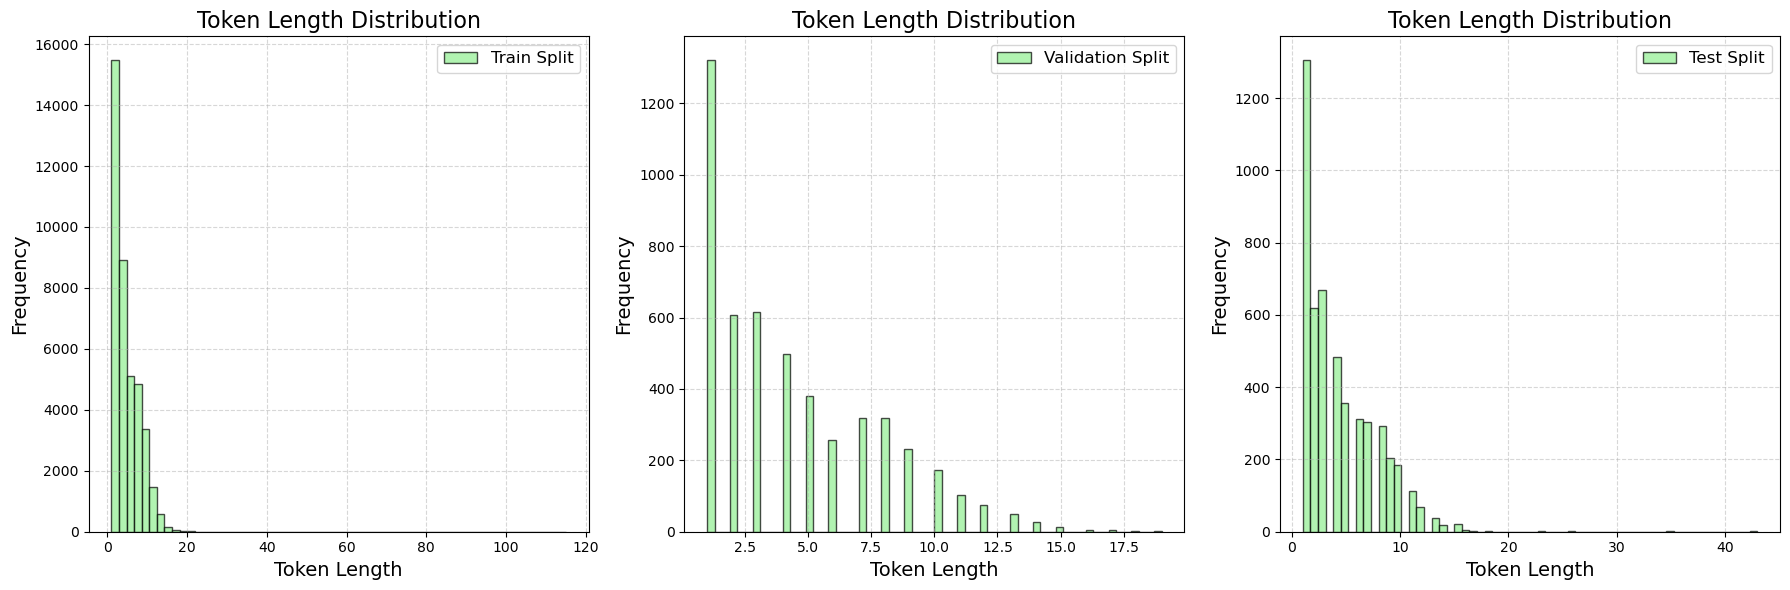

In [31]:
# Create a figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Token Length Distribution - Train
axes[0].hist(train_token_length, bins=60, color='lightgreen', edgecolor='black', alpha=0.7)
axes[0].set_title('Token Length Distribution', fontsize=16)
axes[0].set_xlabel('Token Length', fontsize=14)
axes[0].set_ylabel('Frequency', fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].legend(['Train Split'], loc='upper right', fontsize=12)

# Token Length Distribution - Validation
axes[1].hist(val_token_length, bins=60, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1].set_title('Token Length Distribution', fontsize=16)
axes[1].set_xlabel('Token Length', fontsize=14)
axes[1].set_ylabel('Frequency', fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.5)
axes[1].legend(['Validation Split'], loc='upper right', fontsize=12)

# Token Length Distribution - Test
axes[2].hist(test_token_length, bins=60, color='lightgreen', edgecolor='black', alpha=0.7)
axes[2].set_title('Token Length Distribution', fontsize=16)
axes[2].set_xlabel('Token Length', fontsize=14)
axes[2].set_ylabel('Frequency', fontsize=14)
axes[2].grid(True, linestyle='--', alpha=0.5)
axes[2].legend(['Test Split'], loc='upper right', fontsize=12)

# Tight layout to prevent overlapping
plt.tight_layout()

plt.savefig('token_dist.png')

# Show plots
plt.show()


### NAMED-ENTITY RECOGNITION ANALYSIS AND VISUALIZATION

In [32]:
# Flatten the named entity tags
all_ner_tags = [tag for sublist in datasets['train']['ner_tags'] for tag in sublist]

# Number of unique ner_tag
unique_ner_tags = set(all_ner_tags)
print(f'Number of NER tags: {unique_ner_tags}')
print(len(all_ner_tags))

# Counting the occurance of each ner_tag in train split
count_ner_tags = Counter(all_ner_tags)
print("Distribution of NER Tag:")
for ner_tag, count in count_ner_tags.items():
    print(f'{ner_tag} = Count: {count}')

Number of NER tags: {'B-LF', 'B-O', 'B-AC', 'I-LF'}
40000
Distribution of NER Tag:
B-O = Count: 32971
B-LF = Count: 1462
I-LF = Count: 3231
B-AC = Count: 2336


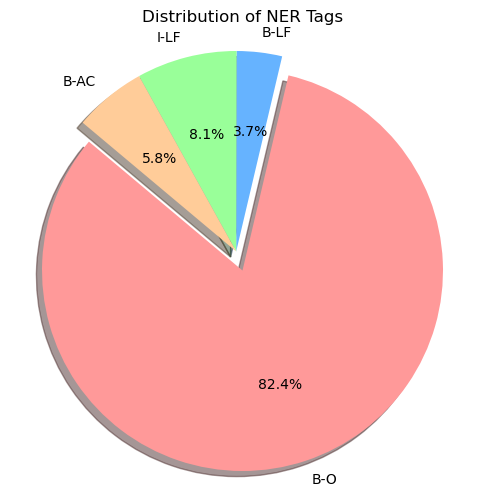

In [33]:
# Calculate the percentages
total_tags = len(all_ner_tags)
percentages = {ner_tag: count / total_tags * 100 for ner_tag, count in count_ner_tags.items()}

# Custom colors for the pie chart
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'] 
explode = (0.1, 0, 0, 0) 
plt.figure(figsize=(6, 6))
plt.pie(percentages.values(), labels=percentages.keys(), autopct='%1.1f%%', startangle=140, colors=colors, explode=explode, shadow=True)
plt.title('Distribution of NER Tags')
plt.axis('equal')
plt.savefig('ner_pie.png')

plt.show()

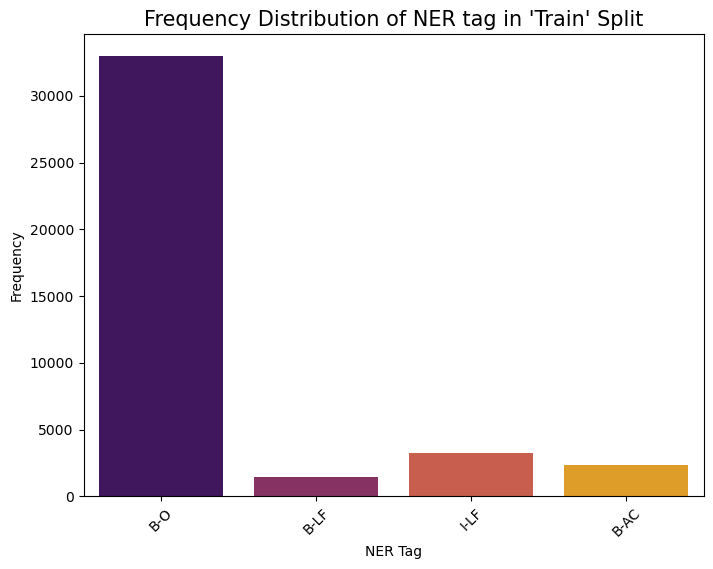

In [34]:
# Plotting the frequency distribution of NER tags
plt.figure(figsize=(8,6), facecolor='white')
sns.barplot(x=list(count_ner_tags.keys()), y=list(count_ner_tags.values()), palette='inferno')
plt.title("Frequency Distribution of NER tag in 'Train' Split", fontsize=15)
plt.xlabel('NER Tag')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

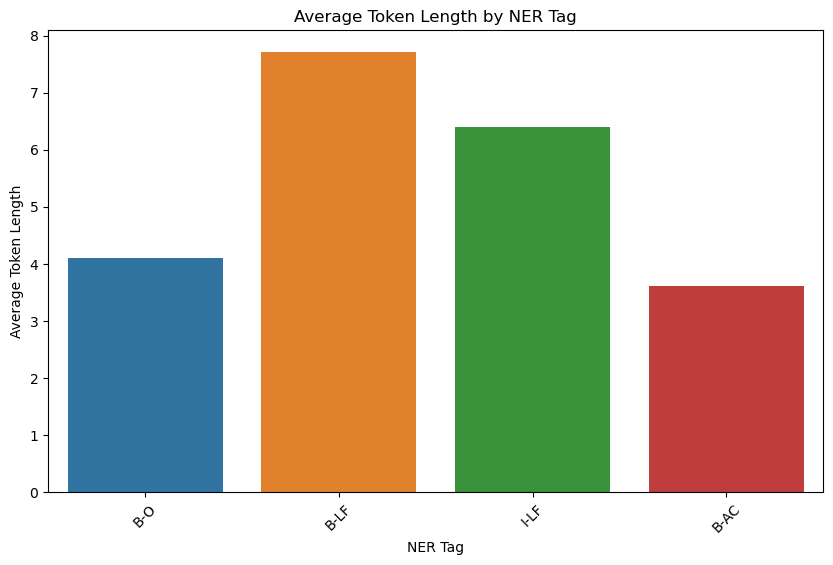

In [35]:
# Function to calculate average token length per NER tag
def average_token_length_per_ner(dataset):
    # Combine tokens and NER tags
    combined = list(zip(dataset['tokens'], dataset['ner_tags']))
    # Calculate average length per NER tag
    ner_lengths = {}
    for tokens, tags in combined:
        for token, tag in zip(tokens, tags):
            if tag not in ner_lengths:
                ner_lengths[tag] = []
            ner_lengths[tag].append(len(token))
    # Calculate average
    for tag in ner_lengths:
        ner_lengths[tag] = np.mean(ner_lengths[tag])
    return ner_lengths

# Calculate for train dataset
train_ner_lengths = average_token_length_per_ner(datasets['train'])

# Visualization
plt.figure(figsize=(10, 6), facecolor='white')
sns.barplot(x=list(train_ner_lengths.keys()), y=list(train_ner_lengths.values()))
plt.xlabel('NER Tag')
plt.ylabel('Average Token Length')
plt.title('Average Token Length by NER Tag')
plt.xticks(rotation=45)
plt.savefig('tok_ner.png')
plt.show()

### PARTS-OF-SPEECH (POS) TAGGING ANALYSIS AND VISUALIZATION

In [36]:
# Flatten the Parts-of-Speech tags
all_pos_tags = [tag for sublist in datasets['train']['pos_tags'] for tag in sublist]

# Number of unique pos_tags
unique_pos_tags = set(all_pos_tags)
print(f'Number of unique POS tags: {unique_pos_tags}')

# Counting the occurance of each pos_tag in train split
count_pos_tags = Counter(all_pos_tags)
print('Distribution of POS Tag:')
for tag, count in count_pos_tags.items():
    print(f'{tag}: {count}')

Number of unique POS tags: {'PUNCT', 'DET', 'CCONJ', 'ADV', 'SCONJ', 'NUM', 'NOUN', 'PRON', 'INTJ', 'X', 'ADP', 'SYM', 'VERB', 'AUX', 'PROPN', 'ADJ', 'PART'}
Distribution of POS Tag:
ADP: 3418
DET: 1931
NOUN: 9999
PROPN: 4419
PUNCT: 8886
AUX: 938
VERB: 2596
ADJ: 3195
CCONJ: 1069
ADV: 584
NUM: 1503
SCONJ: 255
PRON: 463
PART: 292
SYM: 157
X: 294
INTJ: 1


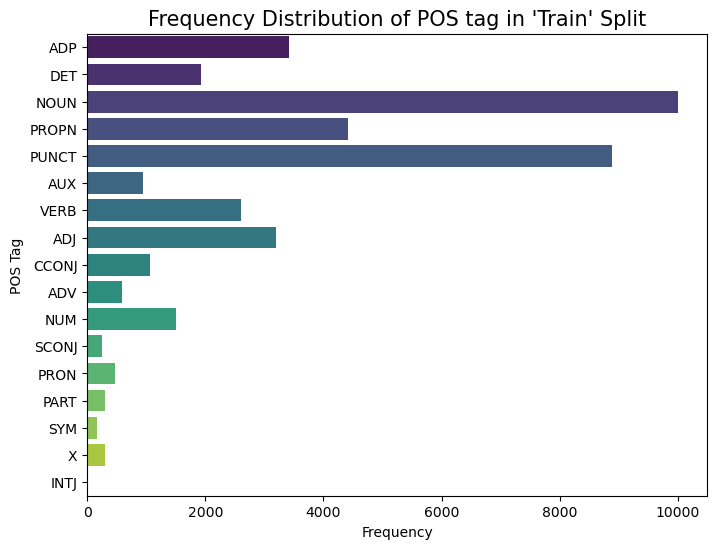

In [37]:
# Plotting the frequency distribution of NER tags
plt.figure(figsize=(8,6), facecolor='white')
sns.barplot(x=list(count_pos_tags.values()), y=list(count_pos_tags.keys()), palette='viridis')
plt.title("Frequency Distribution of POS tag in 'Train' Split", fontsize=15)
plt.xlabel('Frequency')
plt.ylabel('POS Tag')
plt.show()

### STOPWORDS VISUALIZATION

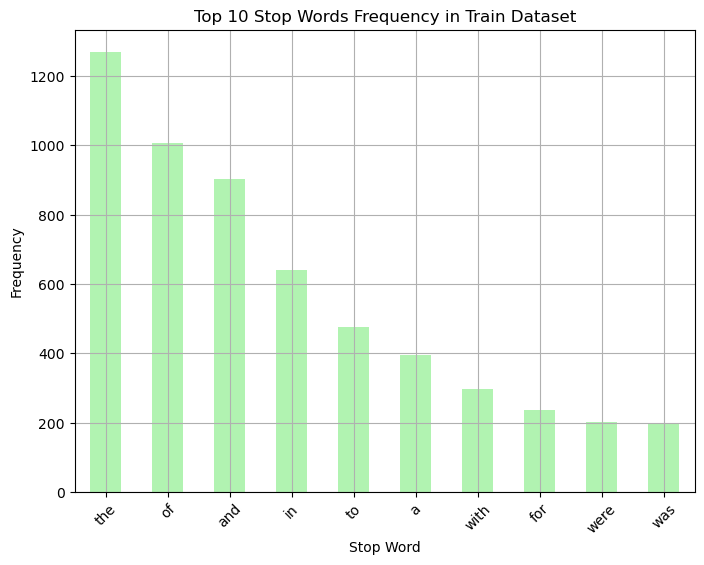

In [38]:
# nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Count the frequency of stop words
stop_words_frequency = Counter([token.lower() for sentence in datasets['train']['tokens'] for token in sentence if token.lower() in stop_words])

# Convert the counter to a DataFrame for better visualization
stop_words_df = pd.DataFrame(stop_words_frequency.items(), columns=['Stop Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Plot the frequency of stop words
plt.figure(figsize=(8, 6), facecolor='white')
stop_words_df.set_index('Stop Word')['Frequency'].nlargest(10).plot(kind='bar', color='lightgreen', alpha=0.7)
plt.title('Top 10 Stop Words Frequency in Train Dataset')
plt.xlabel('Stop Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### WORD CLOUDS

In [39]:
# Generate the word cloud
def generate_wordcloud(dataset):

    wordcloud = WordCloud(width=800, height=400, colormap="Dark2").generate(' '.join(sum(dataset['tokens'], [])))

    # Display the word cloud
    plt.figure(figsize=(10, 5), facecolor='white')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


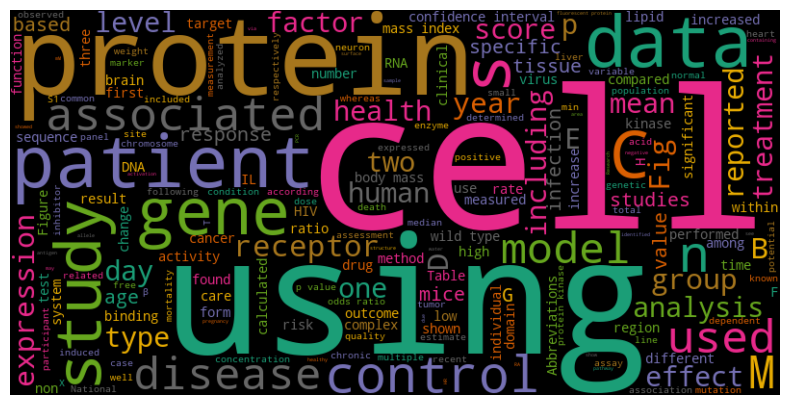

In [40]:
generate_wordcloud(datasets['train'])

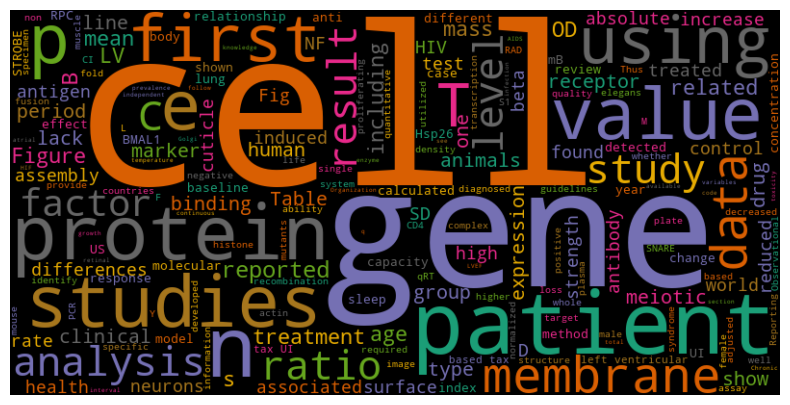

In [41]:
generate_wordcloud(datasets['validation'])

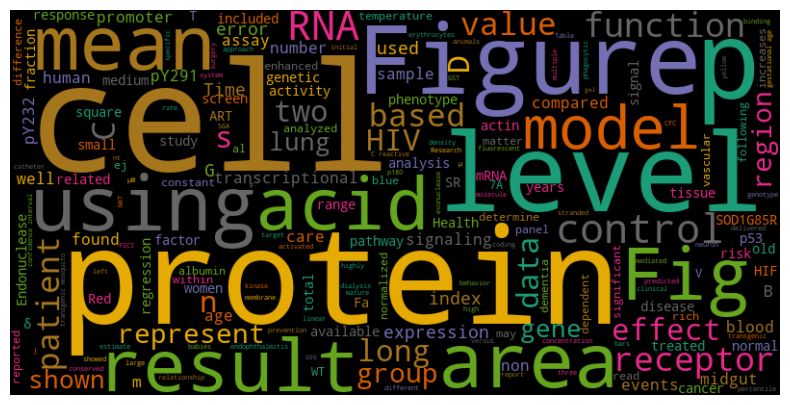

In [42]:
generate_wordcloud(datasets['test'])

# EXPERIMENTATION WITH 4 SETUPS

This coursework consists of four distinct experimental setups for Named Entity Recognition (NER), each conducted in its own notebook. By distributing the experiments across multiple notebooks, we can maintain clarity and organization, making it easier to manage and analyze results. 

_**Links to individual experiment notebook have been provided in this main notebook for easy access and navigation.**_

## Experiment 1: Comparing Different Pre-processing Techniques

In this experiment, I compared different preprocessing techniques to assess the impact of it for NER task. For this setup, I utilized pre-trained BERT model with its tokenizer.

- **System 1:** Preprocessing by Lowercasing
- **System 2:** Preprocessing by Stopword and Punctuation Removal
- **System 3:** Preprocessing by Lemmatization
- **System 4:** All of the above

_Link to [EXPERIMENT 1](EXPERIMENT-1.ipynb)_

## Experiment 2: Comparing Different Loss Functions

In this experiment, I compared the effectiveness of different loss functions and assessed their impact on the NER task. For this, I skipped the preprocessing and just used the pre-trained RoBERTa model with its tokenizer.

- **System 1:** Categorical Cross Entropy Loss
- **System 2:** Label Smoothing with Categorical Cross Entropy
- **System 3:** Focal Loss

_Link to [EXPERIMENT 2](EXPERIMENT-2.ipynb)_


## Experiment 3: Comparing Different Word Embedding Techniques

In this experiment, I chose to compare the effectiveness of different word embeddings in the context of Named Entity Recognition tasks and to assess their impact on model performance. Preprocessing was applied, and the model used was a Keras Sequential BiLSTM model.

- **System 1:** Word2Vec Embeddings
- **System 2:** FastText Embeddings

_Link to [EXPERIMENT 3](EXPERIMENT-3.ipynb)_

## Experiment 4: Extracting Addtional Train/Validate Dataset from PLOD-Filtered

In this experiment, I decided to incorporate addtional training and validation datasets from PLOD-Filtered, which were combined with the original PLOD-CW dataset. The aim here was to explore how different proportions of extracted subsets from larger dataset could enhance the accuracy of abbreivation and long form detection.

With the BEST performing model setup from the above as a baseline, I evaluated perfromance of the model on this augmented dataset.

- **System 1:** Train solely on PLOD-CW
- **System 2:** Additional 1% of data from PLOD-Filtered combined with PLOD-CW.
- **System 3:** Additional 5% of data from PLOD-Filtered combined with PLOD-CW.

_Limited computational resources necessitate the extraction of a small percentage of additonal data to optimize resource utilization while aiming to enhance model performance._

_Link to [EXPERIMENT 4](EXPERIMENT-4.ipynb)_